In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import regex as re

In [2]:
from framefinder import framelabels

candidate_labels = [
    "Economic: costs, benefits, or other financial implications",
    "Capacity and resources: availability of physical, human or financial resources, and capacity of current systems",
    "Morality: religious or ethical implications",
    "Fairness and equality: balance or distribution of rights, responsibilities, and resources",
    "Legality, constitutionality and jurisprudence: rights, freedoms, and authority of individuals, corporations, and government",
    "Policy prescription and evaluation: discussion of specific policies aimed at addressing problems",
    "Crime and punishment: effectiveness and implications of laws and their enforcement",
    "Security and defense: threats to welfare of the individual, community, or nation",
    "Health and safety: health care, sanitation, public safety",
    "Quality of life: threats and opportunities for the individual’s wealth, happiness, and well-being",
    "Cultural identity: traditions, customs, or values of a social group in relation to a policy issue",
    "Public opinion: attitudes and opinions of the general public, including polling and demographics",
    "Political: considerations related to politics and politicians, including lobbying, elections, and attempts to sway voters",
    "External regulation and reputation: international reputation or foreign policy of the U.S.",
    "Other: any coherent group of frames not covered by the above categories",
]

framing_labels = framelabels.FramingLabels("facebook/bart-large-mnli", candidate_labels)

/home/nico/.local/lib/python3.10/site-packages/torch/cuda/__init__.py:141: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


In [3]:
from framefinder import framedimensions

dimensions = [
    "Care: ...acted with kindness, compassion, or empathy, or nurtured another person.",
    "Harm: ...acted with cruelty, or hurt or harmed another person/animal and caused suffering.",
    "Fairness: ...acted in a fair manner, promoting equality, justice, or rights.",
    "Cheating: ...was unfair or cheated, or caused an injustice or engaged in fraud.",
    "Loyalty: ...acted with fidelity, or as a team player, or was loyal or patriotic.",
    "Betrayal: ...acted disloyal, betrayed someone, was disloyal, or was a traitor.",
    "Authority: ...obeyed, or acted with respect for authority or tradition.",
    "Subversion: ...disobeyed or showed disrespect, or engaged in subversion or caused chaos.",
    "Sanctity: ...acted in a way that was wholesome or sacred, or displayed purity or sanctity.",
    "Degredation: ...was depraved, degrading, impure, or unnatural.",
]
pole_names = [
    ("Care", "Harm"),
    ("Fairness", "Cheating"),
    ("Loyalty", "Betrayal"),
    ("Authority", "Subversion"),
    ("Sanctity", "Degredation"),
]
base_model = 'all-mpnet-base-v2'
framing_dimensions = framedimensions.FramingDimensions(base_model, dimensions, pole_names)

In [4]:
import requests

def read_files(filenames):
    files = []
    for file_name in filenames:
        with open("articles/" + file_name, 'r',encoding="utf8") as file:
            files.append(file.read())
    return files

def clean_string(text): # ? might not work for all articles, need to test
    text = re.split(r"==See also==", text)[0] # remove everything after "See also"
    text = re.sub(r'\{\{Asof\|(\d{4})\|(\d{1,2})\}\}', r'as of \2/\1', text) # replace {{Asof|YYYY|MM}} with as of MM/YYYY
    text = re.sub(r'\{\{.*}}', '', text) # remove {{}}
    text = re.sub(r'&lt;!--.*?-->', "", text) # remove <!--...-->  
    text = re.sub(r'\n\* ', '\n', text) # remove enumeration symbol *
    text = re.sub(r'\n#', '\n', text) # remove enumeration symbol #
    text = re.sub(r'&lt;ref.*?&lt;/ref>', "", text) # remove <ref>...</ref>
    text = re.sub(r"&lt;ref.*/>", "", text) # remove <ref ... />
    text = re.sub(r"==+", "", text) # remove ==, ===, ====, ...
    text = re.sub(r"==+", "", text) # remove ==, ===, ====, ...
    text = re.sub(r"'+", "", text) # remove ''', '''', ...
    text = re.sub(r'\xa0', ' ', text) # replace non-breaking space with space
    text = re.sub(r'\[\[File:(?:\[\[[^\]]*?\]\]|.)*?\]\]', "", text) # remove [[File:...]]
    text = re.sub(r'\[\[[^\|\]]*\|([^\]]+)\]\]', r'[[\1]]', text) # replace [[left|right]] with [right]
    text = text.replace(r"[[", "").replace("]]", "") # remove [[ and ]]
    text = re.sub(r'\n+', '\n', text) # replace multiple newlines with one
    return text

def extract_source(text):
    text = re.split(r'<textarea[^>]*>', text)[1]
    return re.split(r'</textarea>', text)[0]
    
def fetch_wiki_articles(articles): # ? might not work for all articles, need to test
    article_texts = []
    for article in articles:
        response = requests.get(f"https://en.wikipedia.org/w/index.php?title={article}&action=edit")
        text = extract_source(response.text)
        article_texts.append(clean_string(text))
    return article_texts

In [5]:
# fetch articles directly from wikipedia or use the ones in the articles folder
article_titles = ["Anti-abortion_movements", "Abortion-rights_movements"]
articles = fetch_wiki_articles(article_titles)
# articles = [clean_string(article) for article in read_files(article_titles)]

In [6]:
# todo maybe split articles into paragraphs
for article in articles:
    print(article)


Anti-abortion movements, also self-styled as pro-life or abolitionist movements, are involved in the abortion debate advocating against the practice of abortion and its legality. Many anti-abortion movements began as countermovements in response to the legalization of elective abortions.
Historical
In the 19th century United States, Anthony Comstock launched an anti-vice crusade that included opposition to contraception and abortion. He successfully got the US congress to pass laws later known as the Comstock laws that included provisions that made it illegal to send materials used for abortion through the mail. These laws have been referenced by modern anti-abortion campaigners in the US and cited in court cases to stop the mailing of abortion medication.
Europe
In Europe, abortion law varies by country, and has been legalized through parliamentary acts in some countries, and constitutionally banned or heavily restricted in others. In Western Europe this has had the effect at once of

100%|██████████| 1/1 [00:00<00:00, 22075.28it/s]


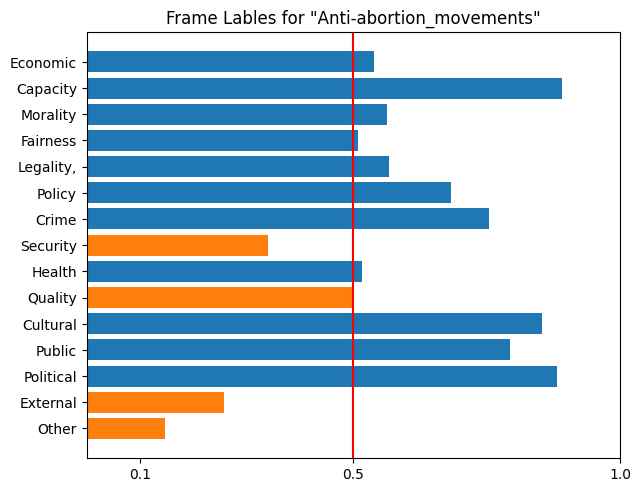

100%|██████████| 1/1 [00:00<00:00, 20867.18it/s]


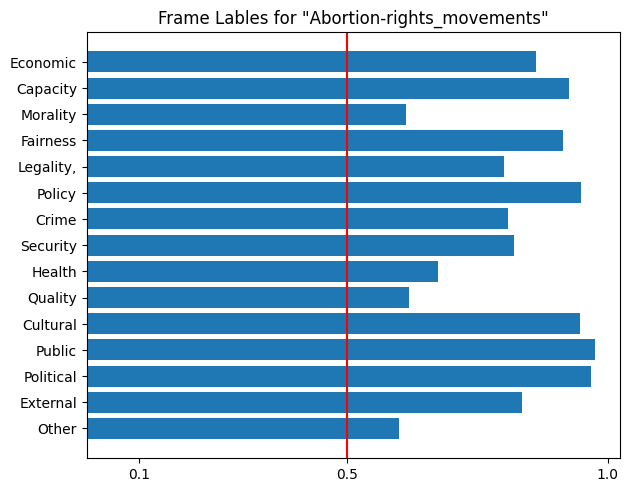

In [12]:
for i in range(len(articles)):
    labels = framing_labels([articles[i]])
    labels_df = pd.DataFrame(labels)
    _, ax = framing_labels.visualize(labels_df.mean().to_dict(), xerr=labels_df.sem())
    ax.xaxis.set_major_formatter(mticker.ScalarFormatter())
    plt.xticks([0.1, 0.5, 1])
    plt.title('Frame Lables for "' + article_titles[i] + '"')
    plt.axvline(0.5, color="red")
    plt.show()

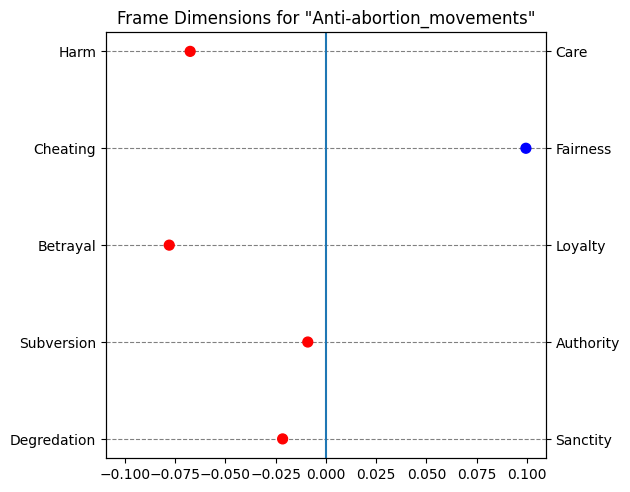

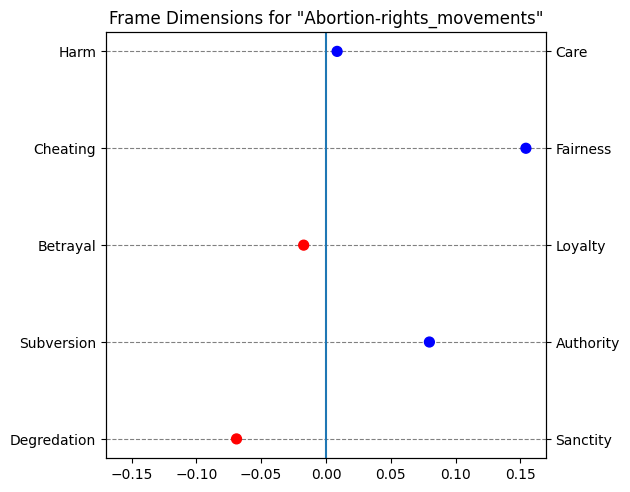

In [11]:
for i in range(len(articles)):
    dimensions = framing_dimensions([articles[i]])
    dimensions_df = pd.DataFrame(dimensions)
    g = framing_dimensions.visualize(dimensions_df)
    g.axes[0].set_axisbelow(True)
    g.axes[0].yaxis.grid(color='gray', linestyle='dashed')
    plt.title('Frame Dimensions for "' + article_titles[i] + '"')

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()